# Comparison between different models for the Kaggle challenge "SETI Breakthrough Listen" 

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn import metrics
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sn
import torch
import torch.nn as nn
import random
from efficientnet_pytorch import model as enet
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
import codecs

In [2]:
def set_seed(seed = 0):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random_state = np.random.RandomState(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)
    return random_state

random_state = set_seed(2021)

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


800 Files -> 640 MB in Folder, the first 800 from the folder "train/0"

--- depends

1600 Files -> 1280 MB in Folder, the first 800 from the folder "train/0", the second 600 from "train/1"

In [4]:
df_train=pd.read_csv('./train_labels_shorted.csv')
df_train.head()

,id,target
0,0000799a2b2c42d,0
1,00042890562ff68,0
2,0005364cdcb8e5b,0
3,0007a5a46901c56,0
4,0009283e145448e,0


In [5]:
df_train['img_path']=df_train['id'].apply(lambda x:f'./train/selectiontrain/{x}.npy')
df_train.head()

,id,target,img_path
0,0000799a2b2c42d,0,./train/selectiontrain/0000799a2b2c42d.npy
1,00042890562ff68,0,./train/selectiontrain/00042890562ff68.npy
2,0005364cdcb8e5b,0,./train/selectiontrain/0005364cdcb8e5b.npy
3,0007a5a46901c56,0,./train/selectiontrain/0007a5a46901c56.npy
4,0009283e145448e,0,./train/selectiontrain/0009283e145448e.npy


800


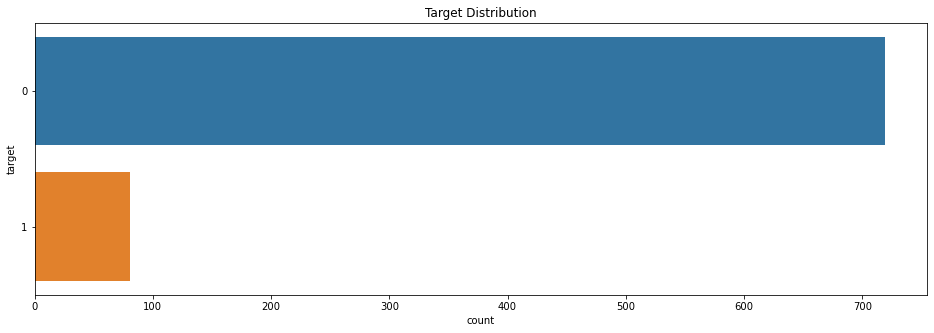

In [6]:
plt.figure(figsize=(16, 5))
sn.countplot(y="target", data=df_train)
plt.title("Target Distribution");
print(len(df_train))

In [7]:
class ClassificationDataset:
    
    def __init__(self, image_paths, targets): 
        self.image_paths = image_paths
        self.targets = targets

    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, item):      
        image = np.load(self.image_paths[item]).astype(float)

        targets = self.targets[item]
                
        return {
            "image": torch.tensor(image, dtype=torch.float),
            "targets": torch.tensor(targets, dtype=torch.long),
        }

In [8]:
class enetv2(nn.Module):
    def __init__(self, backbone, pretrained=False, out_dim=1):
        super(enetv2, self).__init__()
        self.enet = enet.EfficientNet.from_name(backbone)
        if pretrained:
            self.enet.load_state_dict(torch.load(pretrained_model[backbone]))
        self.myfc = nn.Linear(self.enet._fc.in_features, out_dim)
        self.enet._fc = nn.Identity()
        self.conv1 = nn.Conv2d(6, 3, kernel_size=3, stride=1, padding=3, bias=False)

    def extract(self, x):
        return self.enet(x)

    def forward(self, x):
        x = self.conv1(x)
        x = self.extract(x)
        x = self.myfc(x)
        return x

In [9]:
def train(data_loader, model, optimizer, device):
    
    model.train() # Sets to train mode
    
    loss_sum = 0
    
    for data in tqdm(data_loader, position=0, leave=True, desc='Training'):
        inputs = data["image"]
        targets = data['targets']
        
        # Cast
        inputs = inputs.to(device, dtype=torch.float)
        targets = targets.to(device, dtype=torch.float)
        
        optimizer.zero_grad() # Gradient Descent
        outputs = model(inputs) # Output Weights
        loss = nn.BCEWithLogitsLoss()(outputs, targets.view(-1, 1)) # Loss-Berechnung: BCE-Loss + Sigmoid
        loss_sum += loss
        loss.backward()
        optimizer.step()
        
    return loss_sum
        
def evaluate(data_loader, model, device):
    model.eval() # Sets to evaluation mode
    
    final_targets = []
    final_outputs = []
    
    with torch.no_grad():
        loss_sum = 0
        
        for data in tqdm(data_loader, position=0, leave=True, desc='Evaluating'):
            inputs = data["image"]
            targets = data["targets"]
            inputs = inputs.to(device, dtype=torch.float)
            targets = targets.to(device, dtype=torch.float)
            
            output = model(inputs)
            
            loss_sum += nn.BCEWithLogitsLoss()(output, targets.view(-1, 1))
            
            targets = targets.detach().cpu().numpy().tolist()
            output = output.detach().cpu().numpy().tolist()
            
            final_targets.extend(targets)
            final_outputs.extend(output)
            
    return final_outputs, final_targets, loss_sum

In [10]:
baseline_name = 'efficientnet-b1' # Die Architektur bzw. das Netz? Warum ausgerechnet das?
pretrained_model = {
    baseline_name: './checkpoint/efficientnet-b1-dbc7070a.pth' # Checkpoint?
}
models = []
device = "cuda"
Batch_Size = 32
X = df_train.img_path.values
Y = df_train.target.values
#skf = StratifiedKFold(n_splits=5) # Cross Validation 5-fold, mehrschichtig (stratified)
# -> https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html#sphx-glr-auto-examples-model-selection-plot-cv-indices-py)
#fold = 0

starter_models = [enetv2(baseline_name, pretrained=False, out_dim=1), enetv2(baseline_name, pretrained=True, out_dim=1)]
names = ['efficientnet-b1', 'efficientnet-b1-pretrained']
epochs = [0 for i in starter_models]
train_losses = [[] for i in starter_models]
valid_losses = [[] for i in starter_models]
aurocs = [[] for i in starter_models]

it = 0

In [11]:
for model in starter_models:
    train_images, valid_images, train_targets, valid_targets = train_test_split(X, Y)
    #model = enetv2(baseline_name, out_dim=1)
    model.to(device)

    train_dataset = ClassificationDataset(image_paths=train_images, targets=train_targets)
    valid_dataset = ClassificationDataset(image_paths=valid_images, targets=valid_targets)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=Batch_Size,shuffle=True, num_workers=4)
    valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=Batch_Size,shuffle=False, num_workers=4)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    
    best_roc_auc = 0.0
    last_roc_auc = 0.0
    roc_auc = 1.0
    row = 0
    last_loss = 0
    train_loss = 10
    valid_loss = 10

    #for epoch in range(epochs):
    #while abs(last_roc_auc - roc_auc) > 0.001 or row < 2:
    #    if abs(last_roc_auc - roc_auc) < 0.001:
    while abs(last_loss - train_loss) < 0.001 or row < 2 and epochs[it] < 500:
        if abs(last_loss - train_loss) < 0.001:    
            row += 1
        else:
            row = 0
        last_loss = train_loss
        epochs[it] += 1
        last_roc_auc = roc_auc
        train_loss = train(train_loader, model, optimizer, device=device)
        predictions, valid_targets, valid_loss = evaluate(valid_loader, model, device=device)
        roc_auc = metrics.roc_auc_score(valid_targets, predictions)
        
        train_losses[it].append(train_loss.detach().cpu().numpy()) 
        valid_losses[it].append(valid_loss.detach().cpu().numpy())
        aurocs[it].append(roc_auc)
        #f1_score = metrics.f1_score(valid_targets, predictions)
        print(f"Epoch={epochs[it]}, Train Loss={train_loss}, Train Loss Diff={abs(last_loss - train_loss)} Validation Loss={valid_loss}, Validation ROC AUC={roc_auc}, Distance Actual/Last={abs(roc_auc - last_roc_auc)}")

        with codecs.open('log2.log', 'a') as up:
            up.write(f"Model={names[it]}, Epoch={epochs[it]}, Train Loss={train_loss}, Valid Loss={valid_loss} Valid ROC AUC={roc_auc}/{best_roc_auc}\n")

        
    print(f'Model {names[it]} converged after {epochs[it]} epochs.')
    torch.save(model.state_dict(), names[it] + '-' + str(it) + '.pt')
    models.append(model)
    it += 1
    
print('finished')
it = 0

Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.10it/s]


Epoch=1, Train Loss=8.504928588867188, Train Loss Diff=1.4950714111328125 Validation Loss=4.140286445617676, Validation ROC AUC=0.5171588188347964, Distance Actual/Last=0.4828411811652036


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  7.89it/s]


Epoch=2, Train Loss=6.5710272789001465, Train Loss Diff=1.933901309967041 Validation Loss=3.3411760330200195, Validation ROC AUC=0.5, Distance Actual/Last=0.01715881883479642


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  7.83it/s]


Epoch=3, Train Loss=6.7604522705078125, Train Loss Diff=0.18942499160766602 Validation Loss=2.9005937576293945, Validation ROC AUC=0.4692737430167598, Distance Actual/Last=0.03072625698324022


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.47it/s]


Epoch=4, Train Loss=6.859731674194336, Train Loss Diff=0.09927940368652344 Validation Loss=2.383993625640869, Validation ROC AUC=0.4930832668262836, Distance Actual/Last=0.023809523809523836


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.44it/s]


Epoch=5, Train Loss=6.338249683380127, Train Loss Diff=0.521481990814209 Validation Loss=2.397644519805908, Validation ROC AUC=0.5, Distance Actual/Last=0.006916733173716383


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.32it/s]


Epoch=6, Train Loss=6.400005340576172, Train Loss Diff=0.06175565719604492 Validation Loss=2.383606433868408, Validation ROC AUC=0.4582335727587124, Distance Actual/Last=0.041766427241287596


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.35it/s]


Epoch=7, Train Loss=6.471550941467285, Train Loss Diff=0.07154560089111328 Validation Loss=2.505199432373047, Validation ROC AUC=0.5094440010641127, Distance Actual/Last=0.05121042830540029


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.53it/s]


Epoch=8, Train Loss=6.510422706604004, Train Loss Diff=0.03887176513671875 Validation Loss=2.3836569786071777, Validation ROC AUC=0.5274009044958765, Distance Actual/Last=0.017956903431763815


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.45it/s]


Epoch=9, Train Loss=6.296519756317139, Train Loss Diff=0.21390295028686523 Validation Loss=2.796409845352173, Validation ROC AUC=0.46900771481777065, Distance Actual/Last=0.05839318967810586


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.58it/s]


Epoch=10, Train Loss=6.43543815612793, Train Loss Diff=0.13891839981079102 Validation Loss=2.39473295211792, Validation ROC AUC=0.38241553604682094, Distance Actual/Last=0.08659217877094971


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.40it/s]


Epoch=11, Train Loss=6.409748077392578, Train Loss Diff=0.025690078735351562 Validation Loss=2.506006956100464, Validation ROC AUC=0.6252992817238627, Distance Actual/Last=0.2428837456770418


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.26it/s]


Epoch=12, Train Loss=6.247970104217529, Train Loss Diff=0.16177797317504883 Validation Loss=2.506702184677124, Validation ROC AUC=0.614658153764299, Distance Actual/Last=0.010641127959563734


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.37it/s]


Epoch=13, Train Loss=6.239782333374023, Train Loss Diff=0.00818777084350586 Validation Loss=2.4300739765167236, Validation ROC AUC=0.5649108805533386, Distance Actual/Last=0.0497472732109604


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.45it/s]


Epoch=14, Train Loss=6.413204193115234, Train Loss Diff=0.17342185974121094 Validation Loss=2.402254819869995, Validation ROC AUC=0.48124501197126895, Distance Actual/Last=0.08366586858206965


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.42it/s]


Epoch=15, Train Loss=6.121063232421875, Train Loss Diff=0.2921409606933594 Validation Loss=2.5385382175445557, Validation ROC AUC=0.5760840649108805, Distance Actual/Last=0.09483905293961153


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.46it/s]


Epoch=16, Train Loss=6.1680169105529785, Train Loss Diff=0.046953678131103516 Validation Loss=2.4227726459503174, Validation ROC AUC=0.5887204043628624, Distance Actual/Last=0.012636339451981948


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.38it/s]


Epoch=17, Train Loss=6.100118637084961, Train Loss Diff=0.06789827346801758 Validation Loss=2.4225804805755615, Validation ROC AUC=0.5908486299547752, Distance Actual/Last=0.0021282255919127246


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.49it/s]


Epoch=18, Train Loss=6.015030384063721, Train Loss Diff=0.08508825302124023 Validation Loss=2.462599992752075, Validation ROC AUC=0.4594306996541633, Distance Actual/Last=0.13141793030061188


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.08it/s]


Epoch=19, Train Loss=6.030795574188232, Train Loss Diff=0.01576519012451172 Validation Loss=2.4884321689605713, Validation ROC AUC=0.48270816706570896, Distance Actual/Last=0.023277467411545683


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.44it/s]


Epoch=20, Train Loss=5.78961181640625, Train Loss Diff=0.24118375778198242 Validation Loss=2.4461827278137207, Validation ROC AUC=0.4442670923117851, Distance Actual/Last=0.03844107475392389


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.38it/s]


Epoch=21, Train Loss=5.808745384216309, Train Loss Diff=0.019133567810058594 Validation Loss=2.487689733505249, Validation ROC AUC=0.48563447725458897, Distance Actual/Last=0.0413673849428039


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.09it/s]


Epoch=22, Train Loss=5.7304816246032715, Train Loss Diff=0.07826375961303711 Validation Loss=2.4854776859283447, Validation ROC AUC=0.5618515562649641, Distance Actual/Last=0.07621707901037511


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.66it/s]


Epoch=23, Train Loss=5.511291027069092, Train Loss Diff=0.2191905975341797 Validation Loss=2.4107556343078613, Validation ROC AUC=0.4772545889864326, Distance Actual/Last=0.0845969672785315


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.46it/s]


Epoch=24, Train Loss=5.394260406494141, Train Loss Diff=0.11703062057495117 Validation Loss=2.478074073791504, Validation ROC AUC=0.4635541367384943, Distance Actual/Last=0.013700452247938255


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.38it/s]


Epoch=25, Train Loss=5.194966793060303, Train Loss Diff=0.1992936134338379 Validation Loss=2.689983606338501, Validation ROC AUC=0.46395317903697786, Distance Actual/Last=0.0003990422984835318


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  7.88it/s]


Epoch=26, Train Loss=5.380548000335693, Train Loss Diff=0.18558120727539062 Validation Loss=2.560276746749878, Validation ROC AUC=0.5256717212024473, Distance Actual/Last=0.06171854216546946


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.53it/s]


Epoch=27, Train Loss=5.239431858062744, Train Loss Diff=0.14111614227294922 Validation Loss=2.851625919342041, Validation ROC AUC=0.5429635541367385, Distance Actual/Last=0.01729183293429115


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.67it/s]


Epoch=28, Train Loss=5.120952606201172, Train Loss Diff=0.11847925186157227 Validation Loss=2.5997579097747803, Validation ROC AUC=0.5613194998669859, Distance Actual/Last=0.018355945730247458


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.44it/s]


Epoch=29, Train Loss=5.337162494659424, Train Loss Diff=0.21620988845825195 Validation Loss=2.6919679641723633, Validation ROC AUC=0.5166267624368184, Distance Actual/Last=0.04469273743016755


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  7.82it/s]


Epoch=30, Train Loss=4.888134002685547, Train Loss Diff=0.44902849197387695 Validation Loss=3.122973918914795, Validation ROC AUC=0.45171588188347966, Distance Actual/Last=0.06491088055333871


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.11it/s]


Epoch=31, Train Loss=5.33678674697876, Train Loss Diff=0.4486527442932129 Validation Loss=3.0213663578033447, Validation ROC AUC=0.5001330140994945, Distance Actual/Last=0.048417132216014847


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.16it/s]


Epoch=32, Train Loss=5.556440830230713, Train Loss Diff=0.21965408325195312 Validation Loss=3.206573963165283, Validation ROC AUC=0.4320297951582867, Distance Actual/Last=0.0681032189412078


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  7.83it/s]


Epoch=33, Train Loss=5.039133548736572, Train Loss Diff=0.5173072814941406 Validation Loss=3.4646549224853516, Validation ROC AUC=0.42883745677041774, Distance Actual/Last=0.003192338387868976


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  7.64it/s]


Epoch=34, Train Loss=4.532130718231201, Train Loss Diff=0.5070028305053711 Validation Loss=3.0040464401245117, Validation ROC AUC=0.38121840915137006, Distance Actual/Last=0.04761904761904767


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  7.91it/s]


Epoch=35, Train Loss=4.537113189697266, Train Loss Diff=0.004982471466064453 Validation Loss=3.0745491981506348, Validation ROC AUC=0.37243947858473, Distance Actual/Last=0.008778930566640086


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.59it/s]


Epoch=36, Train Loss=4.602934837341309, Train Loss Diff=0.06582164764404297 Validation Loss=2.669567584991455, Validation ROC AUC=0.5206171854216547, Distance Actual/Last=0.14817770683692472


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.81it/s]


Epoch=37, Train Loss=4.361313819885254, Train Loss Diff=0.2416210174560547 Validation Loss=3.7832720279693604, Validation ROC AUC=0.4405426975259378, Distance Actual/Last=0.08007448789571692


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.65it/s]


Epoch=38, Train Loss=3.854063034057617, Train Loss Diff=0.5072507858276367 Validation Loss=3.5506913661956787, Validation ROC AUC=0.4658153764299015, Distance Actual/Last=0.02527267890396373


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.61it/s]


Epoch=39, Train Loss=3.525416612625122, Train Loss Diff=0.3286464214324951 Validation Loss=2.9972918033599854, Validation ROC AUC=0.5857940941739824, Distance Actual/Last=0.11997871774408092


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.66it/s]


Epoch=40, Train Loss=2.9134681224823, Train Loss Diff=0.6119484901428223 Validation Loss=3.9992496967315674, Validation ROC AUC=0.46102686884809785, Distance Actual/Last=0.12476722532588458


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.23it/s]


Epoch=41, Train Loss=3.4735183715820312, Train Loss Diff=0.5600502490997314 Validation Loss=4.41217041015625, Validation ROC AUC=0.4998669859005054, Distance Actual/Last=0.03884011705240753


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.50it/s]


Epoch=42, Train Loss=3.501918077468872, Train Loss Diff=0.02839970588684082 Validation Loss=3.9624147415161133, Validation ROC AUC=0.5011971268954509, Distance Actual/Last=0.00133014099494555


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.47it/s]


Epoch=43, Train Loss=3.2210803031921387, Train Loss Diff=0.2808377742767334 Validation Loss=4.521144866943359, Validation ROC AUC=0.44692737430167595, Distance Actual/Last=0.05426975259377498


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.57it/s]


Epoch=44, Train Loss=3.202944278717041, Train Loss Diff=0.018136024475097656 Validation Loss=4.47935152053833, Validation ROC AUC=0.4070231444533121, Distance Actual/Last=0.03990422984836384


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.57it/s]


Epoch=45, Train Loss=2.624272346496582, Train Loss Diff=0.578671932220459 Validation Loss=3.836289882659912, Validation ROC AUC=0.4993349295025272, Distance Actual/Last=0.09231178504921511


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.38it/s]


Epoch=46, Train Loss=1.9115822315216064, Train Loss Diff=0.7126901149749756 Validation Loss=4.829631328582764, Validation ROC AUC=0.47565841979249796, Distance Actual/Last=0.02367650971002927


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.24it/s]


Epoch=47, Train Loss=2.5412540435791016, Train Loss Diff=0.6296718120574951 Validation Loss=4.1130499839782715, Validation ROC AUC=0.4801808991753125, Distance Actual/Last=0.004522479382814526


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.37it/s]


Epoch=48, Train Loss=2.1546692848205566, Train Loss Diff=0.3865847587585449 Validation Loss=4.579834938049316, Validation ROC AUC=0.5541367384942804, Distance Actual/Last=0.07395583931896788


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.31it/s]


Epoch=49, Train Loss=1.9074382781982422, Train Loss Diff=0.24723100662231445 Validation Loss=3.8087799549102783, Validation ROC AUC=0.5296621441872839, Distance Actual/Last=0.0244745943069965


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.77it/s]


Epoch=50, Train Loss=2.121025800704956, Train Loss Diff=0.21358752250671387 Validation Loss=4.277068138122559, Validation ROC AUC=0.5105081138600691, Distance Actual/Last=0.019154030327214744


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.39it/s]


Epoch=51, Train Loss=1.3432729244232178, Train Loss Diff=0.7777528762817383 Validation Loss=5.373601913452148, Validation ROC AUC=0.515562649640862, Distance Actual/Last=0.005054535780792846


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.68it/s]


Epoch=52, Train Loss=1.9685322046279907, Train Loss Diff=0.625259280204773 Validation Loss=6.124509811401367, Validation ROC AUC=0.43149773876030856, Distance Actual/Last=0.0840649108805534


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.32it/s]


Epoch=53, Train Loss=1.5966631174087524, Train Loss Diff=0.3718690872192383 Validation Loss=6.939026355743408, Validation ROC AUC=0.5163607342378291, Distance Actual/Last=0.08486299547752058


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.52it/s]


Epoch=54, Train Loss=1.090890884399414, Train Loss Diff=0.5057722330093384 Validation Loss=4.630885601043701, Validation ROC AUC=0.607608406491088, Distance Actual/Last=0.09124767225325892


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.67it/s]


Epoch=55, Train Loss=0.935046911239624, Train Loss Diff=0.15584397315979004 Validation Loss=4.168684005737305, Validation ROC AUC=0.4966746475126363, Distance Actual/Last=0.11093375897845176


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.57it/s]


Epoch=56, Train Loss=1.96103036403656, Train Loss Diff=1.025983452796936 Validation Loss=6.352432727813721, Validation ROC AUC=0.567172120244746, Distance Actual/Last=0.07049747273210966


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.64it/s]


Epoch=57, Train Loss=0.9876697063446045, Train Loss Diff=0.9733606576919556 Validation Loss=7.442992687225342, Validation ROC AUC=0.4549082202713488, Distance Actual/Last=0.11226389997339714


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.64it/s]


Epoch=58, Train Loss=0.5745806694030762, Train Loss Diff=0.4130890369415283 Validation Loss=5.654335021972656, Validation ROC AUC=0.5251396648044693, Distance Actual/Last=0.07023144453312047


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.53it/s]


Epoch=59, Train Loss=0.4374566972255707, Train Loss Diff=0.1371239721775055 Validation Loss=6.973584175109863, Validation ROC AUC=0.4998669859005054, Distance Actual/Last=0.025272678903963897


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.46it/s]


Epoch=60, Train Loss=0.25179725885391235, Train Loss Diff=0.18565943837165833 Validation Loss=6.1115336418151855, Validation ROC AUC=0.49880287310454907, Distance Actual/Last=0.0010641127959563068


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.41it/s]


Epoch=61, Train Loss=0.33087316155433655, Train Loss Diff=0.0790759027004242 Validation Loss=7.192581653594971, Validation ROC AUC=0.4847033785581271, Distance Actual/Last=0.014099494546421953


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.36it/s]


Epoch=62, Train Loss=0.232272669672966, Train Loss Diff=0.09860049188137054 Validation Loss=6.702305793762207, Validation ROC AUC=0.5469539771215748, Distance Actual/Last=0.06225059856344767


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.33it/s]


Epoch=63, Train Loss=0.1855672150850296, Train Loss Diff=0.0467054545879364 Validation Loss=7.186874866485596, Validation ROC AUC=0.5152966214418728, Distance Actual/Last=0.03165735567970196


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.35it/s]


Epoch=64, Train Loss=0.5539903044700623, Train Loss Diff=0.36842310428619385 Validation Loss=7.761275768280029, Validation ROC AUC=0.5264698057994147, Distance Actual/Last=0.011173184357541888


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.27it/s]


Epoch=65, Train Loss=0.364990234375, Train Loss Diff=0.18900007009506226 Validation Loss=8.173469543457031, Validation ROC AUC=0.49587656291566906, Distance Actual/Last=0.030593242883745653


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.43it/s]


Epoch=66, Train Loss=0.44257786870002747, Train Loss Diff=0.07758763432502747 Validation Loss=6.2578349113464355, Validation ROC AUC=0.5139664804469274, Distance Actual/Last=0.018089917531258326


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.64it/s]


Epoch=67, Train Loss=1.166211485862732, Train Loss Diff=0.7236336469650269 Validation Loss=5.643019676208496, Validation ROC AUC=0.4889598297419526, Distance Actual/Last=0.025006650704974764


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.33it/s]


Epoch=68, Train Loss=1.1191768646240234, Train Loss Diff=0.047034621238708496 Validation Loss=6.265190124511719, Validation ROC AUC=0.48071295557329075, Distance Actual/Last=0.008246874168661877


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.48it/s]


Epoch=69, Train Loss=1.243816614151001, Train Loss Diff=0.12463974952697754 Validation Loss=9.493690490722656, Validation ROC AUC=0.5352487363660549, Distance Actual/Last=0.05453578079276411


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.43it/s]


Epoch=70, Train Loss=1.1613969802856445, Train Loss Diff=0.08241963386535645 Validation Loss=5.712552070617676, Validation ROC AUC=0.5211492418196328, Distance Actual/Last=0.014099494546422009


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.87it/s]


Epoch=71, Train Loss=0.5181187987327576, Train Loss Diff=0.643278181552887 Validation Loss=6.723060607910156, Validation ROC AUC=0.48443735035913804, Distance Actual/Last=0.036711891460494805


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.44it/s]


Epoch=72, Train Loss=0.14299866557121277, Train Loss Diff=0.3751201331615448 Validation Loss=6.4313483238220215, Validation ROC AUC=0.5150305932428838, Distance Actual/Last=0.030593242883745764


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.41it/s]


Epoch=73, Train Loss=0.518625020980835, Train Loss Diff=0.3756263554096222 Validation Loss=6.988269805908203, Validation ROC AUC=0.5107741420590581, Distance Actual/Last=0.004256451183825671


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.42it/s]


Epoch=74, Train Loss=0.4910305142402649, Train Loss Diff=0.02759450674057007 Validation Loss=7.209901332855225, Validation ROC AUC=0.42697525937749403, Distance Actual/Last=0.0837988826815641


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.51it/s]


Epoch=75, Train Loss=0.4177212417125702, Train Loss Diff=0.0733092725276947 Validation Loss=7.688815593719482, Validation ROC AUC=0.42511306198457033, Distance Actual/Last=0.0018621973929237035


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.44it/s]


Epoch=76, Train Loss=0.2763266861438751, Train Loss Diff=0.14139455556869507 Validation Loss=7.404712677001953, Validation ROC AUC=0.45198191008246874, Distance Actual/Last=0.026868848097898412


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.78it/s]


Epoch=77, Train Loss=0.23031437397003174, Train Loss Diff=0.046012312173843384 Validation Loss=7.214719772338867, Validation ROC AUC=0.4322958233572759, Distance Actual/Last=0.019686086725192842


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.29it/s]


Epoch=78, Train Loss=0.23307384550571442, Train Loss Diff=0.0027594715356826782 Validation Loss=7.4891815185546875, Validation ROC AUC=0.4596967278531524, Distance Actual/Last=0.02740090449587651


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  7.98it/s]


Epoch=79, Train Loss=0.0838981568813324, Train Loss Diff=0.14917568862438202 Validation Loss=7.457524299621582, Validation ROC AUC=0.5083798882681564, Distance Actual/Last=0.04868316041500398


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.16it/s]


Epoch=80, Train Loss=0.20121413469314575, Train Loss Diff=0.11731597781181335 Validation Loss=7.532339572906494, Validation ROC AUC=0.48337323756318173, Distance Actual/Last=0.025006650704974653


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.14it/s]


Epoch=81, Train Loss=0.5142375230789185, Train Loss Diff=0.3130233883857727 Validation Loss=7.551408767700195, Validation ROC AUC=0.5395051875498803, Distance Actual/Last=0.05613194998669857


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  7.92it/s]


Epoch=82, Train Loss=0.4901028871536255, Train Loss Diff=0.02413463592529297 Validation Loss=6.728213310241699, Validation ROC AUC=0.544559723330673, Distance Actual/Last=0.005054535780792735


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.14it/s]


Epoch=83, Train Loss=0.09968872368335724, Train Loss Diff=0.39041417837142944 Validation Loss=6.817361354827881, Validation ROC AUC=0.521415270018622, Distance Actual/Last=0.02314445331205106


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  7.88it/s]


Epoch=84, Train Loss=0.08018061518669128, Train Loss Diff=0.019508108496665955 Validation Loss=6.863018035888672, Validation ROC AUC=0.5107741420590582, Distance Actual/Last=0.010641127959563734


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  7.83it/s]


Epoch=85, Train Loss=0.07166542857885361, Train Loss Diff=0.008515186607837677 Validation Loss=7.109879970550537, Validation ROC AUC=0.5065176908752327, Distance Actual/Last=0.00425645118382556


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.21it/s]


Epoch=86, Train Loss=0.01992938295006752, Train Loss Diff=0.05173604562878609 Validation Loss=7.1659135818481445, Validation ROC AUC=0.4974727321096036, Distance Actual/Last=0.009044958765629107


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.79it/s]


Epoch=87, Train Loss=0.030404599383473396, Train Loss Diff=0.010475216433405876 Validation Loss=7.024514675140381, Validation ROC AUC=0.4897579143389199, Distance Actual/Last=0.0077148177706836685


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.48it/s]


Epoch=88, Train Loss=0.04175626486539841, Train Loss Diff=0.01135166548192501 Validation Loss=7.107635498046875, Validation ROC AUC=0.4839052939611599, Distance Actual/Last=0.0058526203777600205


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.15it/s]


Epoch=89, Train Loss=0.020839150995016098, Train Loss Diff=0.02091711387038231 Validation Loss=7.304073810577393, Validation ROC AUC=0.48443735035913815, Distance Actual/Last=0.0005320563979782644


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.51it/s]


Epoch=90, Train Loss=0.0989341139793396, Train Loss Diff=0.0780949592590332 Validation Loss=7.170083999633789, Validation ROC AUC=0.527267890396382, Distance Actual/Last=0.04283054003724385


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.26it/s]


Epoch=91, Train Loss=0.08659612387418747, Train Loss Diff=0.01233799010515213 Validation Loss=7.59575891494751, Validation ROC AUC=0.4868316041500399, Distance Actual/Last=0.0404362862463421


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.58it/s]


Epoch=92, Train Loss=0.04030175507068634, Train Loss Diff=0.04629436880350113 Validation Loss=7.9164838790893555, Validation ROC AUC=0.48789571694599626, Distance Actual/Last=0.0010641127959563623


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.35it/s]


Epoch=93, Train Loss=0.023646483197808266, Train Loss Diff=0.016655271872878075 Validation Loss=7.864738941192627, Validation ROC AUC=0.4878957169459963, Distance Actual/Last=5.551115123125783e-17


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.69it/s]


Epoch=94, Train Loss=0.020363640040159225, Train Loss Diff=0.0032828431576490402 Validation Loss=7.806924343109131, Validation ROC AUC=0.4950784783187018, Distance Actual/Last=0.0071827613727054596


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.43it/s]


Epoch=95, Train Loss=0.011701016686856747, Train Loss Diff=0.008662623353302479 Validation Loss=7.6368231773376465, Validation ROC AUC=0.5006650704974727, Distance Actual/Last=0.005586592178770888


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.08it/s]


Epoch=96, Train Loss=0.018894929438829422, Train Loss Diff=0.007193912751972675 Validation Loss=7.626384735107422, Validation ROC AUC=0.5091779728651237, Distance Actual/Last=0.00851290236765101


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.64it/s]


Epoch=97, Train Loss=0.018388627097010612, Train Loss Diff=0.0005063023418188095 Validation Loss=7.888867378234863, Validation ROC AUC=0.521415270018622, Distance Actual/Last=0.012237297153498305


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.22it/s]


Epoch=98, Train Loss=0.08240211755037308, Train Loss Diff=0.06401348859071732 Validation Loss=6.399549961090088, Validation ROC AUC=0.536046820963022, Distance Actual/Last=0.014631550944400051


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.02it/s]


Epoch=99, Train Loss=0.14116881787776947, Train Loss Diff=0.05876670032739639 Validation Loss=7.808302879333496, Validation ROC AUC=0.512636339451982, Distance Actual/Last=0.023410481511040082


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.73it/s]


Epoch=100, Train Loss=0.2283220887184143, Train Loss Diff=0.08715327084064484 Validation Loss=8.216285705566406, Validation ROC AUC=0.5198191008246874, Distance Actual/Last=0.0071827613727054596


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.39it/s]


Epoch=101, Train Loss=0.036931708455085754, Train Loss Diff=0.19139038026332855 Validation Loss=9.642621994018555, Validation ROC AUC=0.5293961159882947, Distance Actual/Last=0.009577015163607316


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.44it/s]


Epoch=102, Train Loss=0.04820653051137924, Train Loss Diff=0.011274822056293488 Validation Loss=8.878835678100586, Validation ROC AUC=0.51316839584996, Distance Actual/Last=0.016227720138334734


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.40it/s]


Epoch=103, Train Loss=0.4190828204154968, Train Loss Diff=0.370876282453537 Validation Loss=9.470891952514648, Validation ROC AUC=0.5123703112529928, Distance Actual/Last=0.0007980845969671746


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.35it/s]


Epoch=104, Train Loss=1.1769189834594727, Train Loss Diff=0.7578361630439758 Validation Loss=7.847812652587891, Validation ROC AUC=0.48789571694599626, Distance Actual/Last=0.024474594306996555


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.73it/s]


Epoch=105, Train Loss=0.6714181303977966, Train Loss Diff=0.505500853061676 Validation Loss=9.653311729431152, Validation ROC AUC=0.5453578079276403, Distance Actual/Last=0.057462090981644065


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.59it/s]


Epoch=106, Train Loss=0.5070891380310059, Train Loss Diff=0.16432899236679077 Validation Loss=7.4006500244140625, Validation ROC AUC=0.6320830007980847, Distance Actual/Last=0.08672519287044433


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.28it/s]


Epoch=107, Train Loss=0.6181629300117493, Train Loss Diff=0.11107379198074341 Validation Loss=8.409947395324707, Validation ROC AUC=0.5778132482043097, Distance Actual/Last=0.05426975259377498


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.58it/s]


Epoch=108, Train Loss=0.5198056101799011, Train Loss Diff=0.09835731983184814 Validation Loss=6.9068756103515625, Validation ROC AUC=0.5123703112529928, Distance Actual/Last=0.06544293695131687


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.54it/s]


Epoch=109, Train Loss=0.6023530960083008, Train Loss Diff=0.08254748582839966 Validation Loss=6.653746604919434, Validation ROC AUC=0.518488959829742, Distance Actual/Last=0.006118648576749153


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.66it/s]


Epoch=110, Train Loss=1.0480766296386719, Train Loss Diff=0.4457235336303711 Validation Loss=5.8732476234436035, Validation ROC AUC=0.5347166799680766, Distance Actual/Last=0.016227720138334623


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.75it/s]


Epoch=111, Train Loss=0.9982442259788513, Train Loss Diff=0.04983240365982056 Validation Loss=6.625943183898926, Validation ROC AUC=0.5062516626762437, Distance Actual/Last=0.028465017291832928


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.81it/s]


Epoch=112, Train Loss=0.5974559187889099, Train Loss Diff=0.4007883071899414 Validation Loss=6.7224321365356445, Validation ROC AUC=0.4780526735833998, Distance Actual/Last=0.02819898909284385


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.51it/s]


Epoch=113, Train Loss=1.1154541969299316, Train Loss Diff=0.5179982781410217 Validation Loss=5.583477020263672, Validation ROC AUC=0.49773876030859265, Distance Actual/Last=0.019686086725192842


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.47it/s]


Epoch=114, Train Loss=0.36947324872016907, Train Loss Diff=0.745980978012085 Validation Loss=7.866245269775391, Validation ROC AUC=0.45703644586326153, Distance Actual/Last=0.04070231444533112


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.62it/s]


Epoch=115, Train Loss=0.2966019809246063, Train Loss Diff=0.07287126779556274 Validation Loss=6.56331729888916, Validation ROC AUC=0.4650172918329343, Distance Actual/Last=0.007980845969672745


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.75it/s]


Epoch=116, Train Loss=0.11832606792449951, Train Loss Diff=0.1782759130001068 Validation Loss=7.056268215179443, Validation ROC AUC=0.46102686884809785, Distance Actual/Last=0.003990422984836428


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.71it/s]


Epoch=117, Train Loss=0.04646745324134827, Train Loss Diff=0.07185861468315125 Validation Loss=6.832133769989014, Validation ROC AUC=0.455706304868316, Distance Actual/Last=0.005320563979781867


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.29it/s]


Epoch=118, Train Loss=0.05156209319829941, Train Loss Diff=0.005094639956951141 Validation Loss=7.1655097007751465, Validation ROC AUC=0.4509177972865123, Distance Actual/Last=0.004788507581803658


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.54it/s]


Epoch=119, Train Loss=0.022112172096967697, Train Loss Diff=0.02944992110133171 Validation Loss=7.415338516235352, Validation ROC AUC=0.4455972333067305, Distance Actual/Last=0.005320563979781812


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.51it/s]


Epoch=120, Train Loss=0.01975703239440918, Train Loss Diff=0.0023551397025585175 Validation Loss=7.45756721496582, Validation ROC AUC=0.44985368449055596, Distance Actual/Last=0.004256451183825449


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.44it/s]


Epoch=121, Train Loss=0.03802882134914398, Train Loss Diff=0.018271788954734802 Validation Loss=7.607206344604492, Validation ROC AUC=0.4466613461026869, Distance Actual/Last=0.003192338387869087


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.34it/s]


Epoch=122, Train Loss=0.021510718390345573, Train Loss Diff=0.01651810295879841 Validation Loss=7.792458534240723, Validation ROC AUC=0.4378824155360468, Distance Actual/Last=0.008778930566640086


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.77it/s]


Epoch=123, Train Loss=0.017201997339725494, Train Loss Diff=0.004308721050620079 Validation Loss=7.85902738571167, Validation ROC AUC=0.4314977387603086, Distance Actual/Last=0.006384676775738174


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.17it/s]


Epoch=124, Train Loss=0.016434229910373688, Train Loss Diff=0.0007677674293518066 Validation Loss=7.924712181091309, Validation ROC AUC=0.42803937217345034, Distance Actual/Last=0.0034583665868582747


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.63it/s]


Epoch=125, Train Loss=0.011680982075631618, Train Loss Diff=0.004753247834742069 Validation Loss=8.032236099243164, Validation ROC AUC=0.4259111465815376, Distance Actual/Last=0.0021282255919127246


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.64it/s]


Epoch=126, Train Loss=0.00712191266939044, Train Loss Diff=0.0045590694062411785 Validation Loss=8.076969146728516, Validation ROC AUC=0.4280393721734504, Distance Actual/Last=0.00212822559191278


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.81it/s]


Epoch=127, Train Loss=0.011804929934442043, Train Loss Diff=0.004683017265051603 Validation Loss=7.920145034790039, Validation ROC AUC=0.43202979515828677, Distance Actual/Last=0.003990422984836373


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.23it/s]


Epoch=128, Train Loss=0.011516895145177841, Train Loss Diff=0.0002880347892642021 Validation Loss=7.862708568572998, Validation ROC AUC=0.432827879755254, Distance Actual/Last=0.0007980845969672301


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.36it/s]


Epoch=129, Train Loss=0.004668998531997204, Train Loss Diff=0.006847896613180637 Validation Loss=7.827477931976318, Validation ROC AUC=0.4362862463421122, Distance Actual/Last=0.003458366586858219


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.66it/s]


Epoch=130, Train Loss=0.004591121803969145, Train Loss Diff=7.7876728028059e-05 Validation Loss=7.822811603546143, Validation ROC AUC=0.438680500133014, Distance Actual/Last=0.0023942537909018013


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.06it/s]


Epoch=131, Train Loss=0.18544870615005493, Train Loss Diff=0.1808575838804245 Validation Loss=8.48818588256836, Validation ROC AUC=0.446927374301676, Distance Actual/Last=0.008246874168661988


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.18it/s]


Epoch=132, Train Loss=0.14737339317798615, Train Loss Diff=0.03807531297206879 Validation Loss=8.801363945007324, Validation ROC AUC=0.441340782122905, Distance Actual/Last=0.005586592178770999


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.38it/s]


Epoch=133, Train Loss=0.10645516216754913, Train Loss Diff=0.04091823101043701 Validation Loss=8.844128608703613, Validation ROC AUC=0.43894652833200315, Distance Actual/Last=0.002394253790901857


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.58it/s]


Epoch=134, Train Loss=0.020341800525784492, Train Loss Diff=0.08611336350440979 Validation Loss=8.715941429138184, Validation ROC AUC=0.42511306198457033, Distance Actual/Last=0.013833466347432821


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.40it/s]


Epoch=135, Train Loss=0.03137081116437912, Train Loss Diff=0.011029010638594627 Validation Loss=8.750106811523438, Validation ROC AUC=0.4179303006118648, Distance Actual/Last=0.007182761372705515


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.56it/s]


Epoch=136, Train Loss=0.018314369022846222, Train Loss Diff=0.013056442141532898 Validation Loss=9.290651321411133, Validation ROC AUC=0.4046288906624102, Distance Actual/Last=0.013301409949454612


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.61it/s]


Epoch=137, Train Loss=0.21626386046409607, Train Loss Diff=0.19794949889183044 Validation Loss=8.389017105102539, Validation ROC AUC=0.4631550944400107, Distance Actual/Last=0.05852620377760048


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.47it/s]


Epoch=138, Train Loss=0.08072607219219208, Train Loss Diff=0.135537788271904 Validation Loss=8.84588623046875, Validation ROC AUC=0.46953977121574886, Distance Actual/Last=0.006384676775738174


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.78it/s]


Epoch=139, Train Loss=0.05375051870942116, Train Loss Diff=0.02697555348277092 Validation Loss=8.809732437133789, Validation ROC AUC=0.49587656291566906, Distance Actual/Last=0.026336791699920203


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.37it/s]


Epoch=140, Train Loss=0.4529592990875244, Train Loss Diff=0.39920878410339355 Validation Loss=7.36338996887207, Validation ROC AUC=0.5073157754722, Distance Actual/Last=0.011439212556530909


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.34it/s]


Epoch=141, Train Loss=0.5351963043212891, Train Loss Diff=0.08223700523376465 Validation Loss=9.557340621948242, Validation ROC AUC=0.43096568236233046, Distance Actual/Last=0.07635009310986951


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.23it/s]


Epoch=142, Train Loss=0.8816962242126465, Train Loss Diff=0.3464999198913574 Validation Loss=9.767965316772461, Validation ROC AUC=0.4038308060654429, Distance Actual/Last=0.027134876296887545


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.41it/s]


Epoch=143, Train Loss=1.391158103942871, Train Loss Diff=0.5094618797302246 Validation Loss=7.516129970550537, Validation ROC AUC=0.5514764565043895, Distance Actual/Last=0.14764565043894656


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.70it/s]


Epoch=144, Train Loss=0.4670306444168091, Train Loss Diff=0.924127459526062 Validation Loss=7.644698143005371, Validation ROC AUC=0.43708433093907956, Distance Actual/Last=0.11439212556530992


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.38it/s]


Epoch=145, Train Loss=0.24504928290843964, Train Loss Diff=0.22198136150836945 Validation Loss=6.420821189880371, Validation ROC AUC=0.5432295823357276, Distance Actual/Last=0.10614525139664804


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.63it/s]


Epoch=146, Train Loss=0.13430140912532806, Train Loss Diff=0.11074787378311157 Validation Loss=6.911226272583008, Validation ROC AUC=0.5493482309124768, Distance Actual/Last=0.006118648576749153


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.64it/s]


Epoch=147, Train Loss=0.03638046234846115, Train Loss Diff=0.09792094677686691 Validation Loss=7.410086631774902, Validation ROC AUC=0.5541367384942804, Distance Actual/Last=0.004788507581803603


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.30it/s]


Epoch=148, Train Loss=0.048891693353652954, Train Loss Diff=0.012511231005191803 Validation Loss=8.393699645996094, Validation ROC AUC=0.5368449055599893, Distance Actual/Last=0.01729183293429104


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.60it/s]


Epoch=149, Train Loss=0.04594998061656952, Train Loss Diff=0.002941712737083435 Validation Loss=8.341537475585938, Validation ROC AUC=0.5597233306730514, Distance Actual/Last=0.02287842511306204


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.59it/s]


Epoch=150, Train Loss=0.014332796446979046, Train Loss Diff=0.0316171832382679 Validation Loss=8.548786163330078, Validation ROC AUC=0.5711625432295824, Distance Actual/Last=0.01143921255653102


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.47it/s]


Epoch=151, Train Loss=0.0734233483672142, Train Loss Diff=0.05909055098891258 Validation Loss=8.198318481445312, Validation ROC AUC=0.5567970204841712, Distance Actual/Last=0.014365522745411141


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.34it/s]


Epoch=152, Train Loss=0.03169960528612137, Train Loss Diff=0.041723743081092834 Validation Loss=8.609094619750977, Validation ROC AUC=0.5485501463155094, Distance Actual/Last=0.008246874168661877


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.59it/s]


Epoch=153, Train Loss=0.061523500829935074, Train Loss Diff=0.029823895543813705 Validation Loss=8.62596607208252, Validation ROC AUC=0.5323224261771747, Distance Actual/Last=0.016227720138334623


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.17it/s]


Epoch=154, Train Loss=0.05604907497763634, Train Loss Diff=0.005474425852298737 Validation Loss=8.778732299804688, Validation ROC AUC=0.5285980313913274, Distance Actual/Last=0.003724394785847296


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.24it/s]


Epoch=155, Train Loss=0.2611105144023895, Train Loss Diff=0.2050614356994629 Validation Loss=7.577714920043945, Validation ROC AUC=0.5307262569832403, Distance Actual/Last=0.0021282255919128357


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.39it/s]


Epoch=156, Train Loss=0.12797428667545319, Train Loss Diff=0.13313622772693634 Validation Loss=8.351037979125977, Validation ROC AUC=0.47778664538441074, Distance Actual/Last=0.05293961159882954


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.29it/s]


Epoch=157, Train Loss=0.0969507247209549, Train Loss Diff=0.03102356195449829 Validation Loss=9.409798622131348, Validation ROC AUC=0.4573024740622506, Distance Actual/Last=0.020484171322160127


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.38it/s]


Epoch=158, Train Loss=0.34319600462913513, Train Loss Diff=0.24624527990818024 Validation Loss=10.30606460571289, Validation ROC AUC=0.5091779728651237, Distance Actual/Last=0.051875498802873066


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.85it/s]


Epoch=159, Train Loss=0.08657379448413849, Train Loss Diff=0.25662219524383545 Validation Loss=9.755102157592773, Validation ROC AUC=0.47273210960361794, Distance Actual/Last=0.03644586326150573


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.24it/s]


Epoch=160, Train Loss=0.061638474464416504, Train Loss Diff=0.024935320019721985 Validation Loss=10.325700759887695, Validation ROC AUC=0.47592444799148703, Distance Actual/Last=0.003192338387869087


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.65it/s]


Epoch=161, Train Loss=0.05663229525089264, Train Loss Diff=0.005006179213523865 Validation Loss=10.036908149719238, Validation ROC AUC=0.509976057462091, Distance Actual/Last=0.03405160947060393


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.08it/s]


Epoch=162, Train Loss=0.011088450439274311, Train Loss Diff=0.0455438457429409 Validation Loss=9.95392894744873, Validation ROC AUC=0.5371109337589784, Distance Actual/Last=0.02713487629688749


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.37it/s]


Epoch=163, Train Loss=0.05680526793003082, Train Loss Diff=0.045716818422079086 Validation Loss=9.946149826049805, Validation ROC AUC=0.5254056930034583, Distance Actual/Last=0.011705240755520152


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.66it/s]


Epoch=164, Train Loss=0.029636790975928307, Train Loss Diff=0.027168476954102516 Validation Loss=10.51498794555664, Validation ROC AUC=0.5254056930034583, Distance Actual/Last=0.0


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.16it/s]


Epoch=165, Train Loss=0.046657074242830276, Train Loss Diff=0.01702028326690197 Validation Loss=9.94990348815918, Validation ROC AUC=0.49561053471668, Distance Actual/Last=0.02979515828677831


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.56it/s]


Epoch=166, Train Loss=0.15356013178825378, Train Loss Diff=0.1069030612707138 Validation Loss=10.937933921813965, Validation ROC AUC=0.48417132216014896, Distance Actual/Last=0.01143921255653102


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.55it/s]


Epoch=167, Train Loss=0.04695442318916321, Train Loss Diff=0.10660570859909058 Validation Loss=11.367250442504883, Validation ROC AUC=0.5437616387337059, Distance Actual/Last=0.0595903165735569


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.73it/s]


Epoch=168, Train Loss=0.14830352365970612, Train Loss Diff=0.10134910047054291 Validation Loss=9.12803840637207, Validation ROC AUC=0.581803671189146, Distance Actual/Last=0.03804203245544013


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.28it/s]


Epoch=169, Train Loss=0.16830286383628845, Train Loss Diff=0.019999340176582336 Validation Loss=10.082549095153809, Validation ROC AUC=0.538973131151902, Distance Actual/Last=0.04283054003724396


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.52it/s]


Epoch=170, Train Loss=0.1115332618355751, Train Loss Diff=0.05676960200071335 Validation Loss=9.582003593444824, Validation ROC AUC=0.521415270018622, Distance Actual/Last=0.01755786113328006


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.58it/s]


Epoch=171, Train Loss=0.4680883288383484, Train Loss Diff=0.3565550744533539 Validation Loss=10.175719261169434, Validation ROC AUC=0.47991487097632346, Distance Actual/Last=0.04150039904229852


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.66it/s]


Epoch=172, Train Loss=0.4635857045650482, Train Loss Diff=0.004502624273300171 Validation Loss=7.729221820831299, Validation ROC AUC=0.4894918861399308, Distance Actual/Last=0.009577015163607316


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.51it/s]


Epoch=173, Train Loss=0.39981138706207275, Train Loss Diff=0.06377431750297546 Validation Loss=9.954010009765625, Validation ROC AUC=0.4541101356743814, Distance Actual/Last=0.035381750465549366


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.50it/s]


Epoch=174, Train Loss=0.2884843051433563, Train Loss Diff=0.11132708191871643 Validation Loss=8.622023582458496, Validation ROC AUC=0.5123703112529928, Distance Actual/Last=0.058260175578611406


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.42it/s]


Epoch=175, Train Loss=0.024218542501330376, Train Loss Diff=0.264265775680542 Validation Loss=8.297629356384277, Validation ROC AUC=0.535780792764033, Distance Actual/Last=0.023410481511040193


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.67it/s]


Epoch=176, Train Loss=0.20518921315670013, Train Loss Diff=0.1809706687927246 Validation Loss=8.531237602233887, Validation ROC AUC=0.5453578079276403, Distance Actual/Last=0.009577015163607316


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.13it/s]


Epoch=177, Train Loss=0.20951153337955475, Train Loss Diff=0.004322320222854614 Validation Loss=9.00960636138916, Validation ROC AUC=0.5160947060388401, Distance Actual/Last=0.029263101888800214


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.02it/s]


Epoch=178, Train Loss=0.019247492775321007, Train Loss Diff=0.1902640461921692 Validation Loss=9.170821189880371, Validation ROC AUC=0.5057196062782655, Distance Actual/Last=0.010375099760574602


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.55it/s]


Epoch=179, Train Loss=0.013962197117507458, Train Loss Diff=0.005285295657813549 Validation Loss=9.275290489196777, Validation ROC AUC=0.5033253524873637, Distance Actual/Last=0.002394253790901857


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.46it/s]


Epoch=180, Train Loss=0.02569522149860859, Train Loss Diff=0.011733024381101131 Validation Loss=9.251522064208984, Validation ROC AUC=0.5011971268954509, Distance Actual/Last=0.0021282255919127246


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.15it/s]


Epoch=181, Train Loss=0.035357896238565445, Train Loss Diff=0.009662674739956856 Validation Loss=9.317615509033203, Validation ROC AUC=0.4993349295025273, Distance Actual/Last=0.001862197392923648


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  7.99it/s]


Epoch=182, Train Loss=0.017321715131402016, Train Loss Diff=0.01803618110716343 Validation Loss=9.294178009033203, Validation ROC AUC=0.5035913806863528, Distance Actual/Last=0.004256451183825505


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.39it/s]


Epoch=183, Train Loss=0.03712577000260353, Train Loss Diff=0.019804054871201515 Validation Loss=9.016735076904297, Validation ROC AUC=0.5179569034317637, Distance Actual/Last=0.014365522745410919


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.49it/s]


Epoch=184, Train Loss=0.01989399455487728, Train Loss Diff=0.01723177544772625 Validation Loss=9.153481483459473, Validation ROC AUC=0.5091779728651237, Distance Actual/Last=0.00877893056664003


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.52it/s]


Epoch=185, Train Loss=0.005542645696550608, Train Loss Diff=0.01435134932398796 Validation Loss=9.148109436035156, Validation ROC AUC=0.5038574088853418, Distance Actual/Last=0.005320563979781867


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.43it/s]


Epoch=186, Train Loss=0.0030587762594223022, Train Loss Diff=0.0024838694371283054 Validation Loss=9.139684677124023, Validation ROC AUC=0.5027932960893855, Distance Actual/Last=0.0010641127959563068


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.31it/s]


Epoch=187, Train Loss=0.26632803678512573, Train Loss Diff=0.26326924562454224 Validation Loss=9.034618377685547, Validation ROC AUC=0.5323224261771748, Distance Actual/Last=0.029529130087789346


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.33it/s]


Epoch=188, Train Loss=0.013332544825971127, Train Loss Diff=0.25299549102783203 Validation Loss=8.851720809936523, Validation ROC AUC=0.5344506517690876, Distance Actual/Last=0.0021282255919127246


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.53it/s]


Epoch=189, Train Loss=0.014647226780653, Train Loss Diff=0.0013146819546818733 Validation Loss=8.556466102600098, Validation ROC AUC=0.5344506517690875, Distance Actual/Last=1.1102230246251565e-16


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.82it/s]


Epoch=190, Train Loss=0.01980697549879551, Train Loss Diff=0.0051597487181425095 Validation Loss=8.590715408325195, Validation ROC AUC=0.5230114392125566, Distance Actual/Last=0.011439212556530909


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.21it/s]


Epoch=191, Train Loss=0.009012306109070778, Train Loss Diff=0.010794669389724731 Validation Loss=8.605701446533203, Validation ROC AUC=0.5277999467943602, Distance Actual/Last=0.004788507581803603


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.42it/s]


Epoch=192, Train Loss=0.0032750891987234354, Train Loss Diff=0.005737217143177986 Validation Loss=8.61989688873291, Validation ROC AUC=0.5259377494014366, Distance Actual/Last=0.0018621973929235924


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.37it/s]


Epoch=193, Train Loss=0.009315836243331432, Train Loss Diff=0.006040747277438641 Validation Loss=8.715020179748535, Validation ROC AUC=0.5227454110135674, Distance Actual/Last=0.0031923383878691425


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.33it/s]


Epoch=194, Train Loss=0.002642328618094325, Train Loss Diff=0.006673507392406464 Validation Loss=8.761507987976074, Validation ROC AUC=0.521681298217611, Distance Actual/Last=0.0010641127959564178


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.48it/s]


Epoch=195, Train Loss=0.0018012513173744082, Train Loss Diff=0.0008410773007199168 Validation Loss=8.778827667236328, Validation ROC AUC=0.5211492418196328, Distance Actual/Last=0.0005320563979781534


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.31it/s]


Epoch=196, Train Loss=0.001737344777211547, Train Loss Diff=6.390654016286135e-05 Validation Loss=8.79893970489502, Validation ROC AUC=0.5203511572226656, Distance Actual/Last=0.0007980845969672856


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.57it/s]


Epoch=197, Train Loss=0.003374558174982667, Train Loss Diff=0.00163721339777112 Validation Loss=8.868162155151367, Validation ROC AUC=0.5179569034317638, Distance Actual/Last=0.002394253790901746
Model efficientnet-b1 converged after 197 epochs.


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.53it/s]


Epoch=1, Train Loss=8.376314163208008, Train Loss Diff=1.6236858367919922 Validation Loss=2.8656716346740723, Validation ROC AUC=0.4414073858679849, Distance Actual/Last=0.5585926141320151


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.59it/s]


Epoch=2, Train Loss=5.559913158416748, Train Loss Diff=2.8164010047912598 Validation Loss=3.440093517303467, Validation ROC AUC=0.5588833963361441, Distance Actual/Last=0.11747601046815925


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.32it/s]


Epoch=3, Train Loss=3.0729823112487793, Train Loss Diff=2.4869308471679688 Validation Loss=4.238805770874023, Validation ROC AUC=0.44169816807211393, Distance Actual/Last=0.11718522826403022


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.76it/s]


Epoch=4, Train Loss=1.6151782274246216, Train Loss Diff=1.4578040838241577 Validation Loss=8.193984031677246, Validation ROC AUC=0.3736551323059028, Distance Actual/Last=0.06804303576621112


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.60it/s]


Epoch=5, Train Loss=1.6725965738296509, Train Loss Diff=0.0574183464050293 Validation Loss=7.1859354972839355, Validation ROC AUC=0.46641465542308813, Distance Actual/Last=0.09275952311718533


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.42it/s]


Epoch=6, Train Loss=0.825039803981781, Train Loss Diff=0.8475567698478699 Validation Loss=7.674947738647461, Validation ROC AUC=0.4483861587670835, Distance Actual/Last=0.018028496656004644


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.36it/s]


Epoch=7, Train Loss=0.9313309788703918, Train Loss Diff=0.10629117488861084 Validation Loss=9.322900772094727, Validation ROC AUC=0.5181738877580692, Distance Actual/Last=0.06978772899098568


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.67it/s]


Epoch=8, Train Loss=1.9242404699325562, Train Loss Diff=0.9929094910621643 Validation Loss=10.967527389526367, Validation ROC AUC=0.43966269264321023, Distance Actual/Last=0.07851119511485893


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.40it/s]


Epoch=9, Train Loss=2.1329498291015625, Train Loss Diff=0.20870935916900635 Validation Loss=4.307857513427734, Validation ROC AUC=0.5030532131433556, Distance Actual/Last=0.06339052050014538


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.65it/s]


Epoch=10, Train Loss=1.6314904689788818, Train Loss Diff=0.5014593601226807 Validation Loss=5.40694522857666, Validation ROC AUC=0.5126490258796161, Distance Actual/Last=0.009595812736260534


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.45it/s]


Epoch=11, Train Loss=0.7762932181358337, Train Loss Diff=0.8551972508430481 Validation Loss=6.303590297698975, Validation ROC AUC=0.42890375109043327, Distance Actual/Last=0.08374527478918287


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.39it/s]


Epoch=12, Train Loss=0.3392951190471649, Train Loss Diff=0.4369980990886688 Validation Loss=6.31320858001709, Validation ROC AUC=0.4355917417854027, Distance Actual/Last=0.006687990694969448


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.60it/s]


Epoch=13, Train Loss=0.13935905694961548, Train Loss Diff=0.19993606209754944 Validation Loss=6.676403045654297, Validation ROC AUC=0.45594649607444027, Distance Actual/Last=0.020354754289037547


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.37it/s]


Epoch=14, Train Loss=0.11715832352638245, Train Loss Diff=0.022200733423233032 Validation Loss=7.473077297210693, Validation ROC AUC=0.45943588252398954, Distance Actual/Last=0.00348938644954927


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.47it/s]


Epoch=15, Train Loss=0.09391877055168152, Train Loss Diff=0.023239552974700928 Validation Loss=7.012378692626953, Validation ROC AUC=0.47455655713870315, Distance Actual/Last=0.015120674614713614


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.34it/s]


Epoch=16, Train Loss=0.5655184388160706, Train Loss Diff=0.47159966826438904 Validation Loss=7.47064208984375, Validation ROC AUC=0.4876417563245129, Distance Actual/Last=0.013085199185809748


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.77it/s]


Epoch=17, Train Loss=0.5718003511428833, Train Loss Diff=0.006281912326812744 Validation Loss=7.797328948974609, Validation ROC AUC=0.46263448676940966, Distance Actual/Last=0.02500726955510324


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.46it/s]


Epoch=18, Train Loss=0.4293869137763977, Train Loss Diff=0.1424134373664856 Validation Loss=7.534975051879883, Validation ROC AUC=0.5902878743820877, Distance Actual/Last=0.12765338761267808


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.45it/s]


Epoch=19, Train Loss=0.7746331691741943, Train Loss Diff=0.34524625539779663 Validation Loss=8.186861991882324, Validation ROC AUC=0.5769118929921488, Distance Actual/Last=0.013375981389938896


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.58it/s]


Epoch=20, Train Loss=1.3690261840820312, Train Loss Diff=0.5943930149078369 Validation Loss=5.130350589752197, Validation ROC AUC=0.5760395463797615, Distance Actual/Last=0.0008723466123873314


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.72it/s]


Epoch=21, Train Loss=0.3484959304332733, Train Loss Diff=1.0205302238464355 Validation Loss=7.80556058883667, Validation ROC AUC=0.5085780750218087, Distance Actual/Last=0.06746147135795277


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.62it/s]


Epoch=22, Train Loss=0.5513739585876465, Train Loss Diff=0.20287802815437317 Validation Loss=10.986763954162598, Validation ROC AUC=0.528351264902588, Distance Actual/Last=0.01977318988077925


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.46it/s]


Epoch=23, Train Loss=0.5690768957138062, Train Loss Diff=0.017702937126159668 Validation Loss=6.1175007820129395, Validation ROC AUC=0.4475138121546961, Distance Actual/Last=0.08083745274789189


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.31it/s]


Epoch=24, Train Loss=0.8190199136734009, Train Loss Diff=0.24994301795959473 Validation Loss=6.874098300933838, Validation ROC AUC=0.5615004361733062, Distance Actual/Last=0.11398662401861015


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.10it/s]


Epoch=25, Train Loss=1.28255033493042, Train Loss Diff=0.46353042125701904 Validation Loss=5.523638725280762, Validation ROC AUC=0.5292236115149753, Distance Actual/Last=0.03227682465833093


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.33it/s]


Epoch=26, Train Loss=0.9448937177658081, Train Loss Diff=0.3376566171646118 Validation Loss=5.226924419403076, Validation ROC AUC=0.6080255888339634, Distance Actual/Last=0.07880197731898808


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.35it/s]


Epoch=27, Train Loss=0.8799341320991516, Train Loss Diff=0.0649595856666565 Validation Loss=9.212141036987305, Validation ROC AUC=0.46583309101482984, Distance Actual/Last=0.14219249781913357


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.62it/s]


Epoch=28, Train Loss=0.4612705111503601, Train Loss Diff=0.4186636209487915 Validation Loss=12.04966926574707, Validation ROC AUC=0.4675777842396045, Distance Actual/Last=0.0017446932247746627


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.81it/s]


Epoch=29, Train Loss=0.48023533821105957, Train Loss Diff=0.018964827060699463 Validation Loss=12.22064208984375, Validation ROC AUC=0.42657749345740037, Distance Actual/Last=0.04100029078220413


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.07it/s]


Epoch=30, Train Loss=0.27154913544654846, Train Loss Diff=0.2086862027645111 Validation Loss=9.715400695800781, Validation ROC AUC=0.4664146554230881, Distance Actual/Last=0.039837161965687706


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.01it/s]


Epoch=31, Train Loss=0.5137797594070435, Train Loss Diff=0.242230623960495 Validation Loss=7.776568412780762, Validation ROC AUC=0.44402442570514683, Distance Actual/Last=0.022390229717941246


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.33it/s]


Epoch=32, Train Loss=0.353265643119812, Train Loss Diff=0.16051411628723145 Validation Loss=9.301627159118652, Validation ROC AUC=0.46118057574876414, Distance Actual/Last=0.017156150043617313


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  7.95it/s]


Epoch=33, Train Loss=0.546386182308197, Train Loss Diff=0.193120539188385 Validation Loss=8.638078689575195, Validation ROC AUC=0.44053503925559756, Distance Actual/Last=0.020645536493166583


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  7.72it/s]


Epoch=34, Train Loss=0.324381560087204, Train Loss Diff=0.22200462222099304 Validation Loss=9.768392562866211, Validation ROC AUC=0.4376272172143065, Distance Actual/Last=0.002907822041291086


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.48it/s]


Epoch=35, Train Loss=0.11277702450752258, Train Loss Diff=0.2116045355796814 Validation Loss=7.719969272613525, Validation ROC AUC=0.49229427159057865, Distance Actual/Last=0.05466705437627217


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.61it/s]


Epoch=36, Train Loss=0.11190450191497803, Train Loss Diff=0.0008725225925445557 Validation Loss=8.52615737915039, Validation ROC AUC=0.4922942715905787, Distance Actual/Last=5.551115123125783e-17


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.63it/s]


Epoch=37, Train Loss=0.17388024926185608, Train Loss Diff=0.06197574734687805 Validation Loss=8.5640230178833, Validation ROC AUC=0.49258505379470774, Distance Actual/Last=0.00029078220412903644


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.64it/s]


Epoch=38, Train Loss=0.5828414559364319, Train Loss Diff=0.4089612066745758 Validation Loss=6.763614177703857, Validation ROC AUC=0.46728700203547535, Distance Actual/Last=0.025298051759232387


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.31it/s]


Epoch=39, Train Loss=0.18072238564491272, Train Loss Diff=0.40211907029151917 Validation Loss=6.048249244689941, Validation ROC AUC=0.4908403605699331, Distance Actual/Last=0.023553358534457725


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.68it/s]


Epoch=40, Train Loss=0.0823773518204689, Train Loss Diff=0.09834503382444382 Validation Loss=8.017518997192383, Validation ROC AUC=0.44547833672579235, Distance Actual/Last=0.04536202384414073


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.62it/s]


Epoch=41, Train Loss=0.11556806415319443, Train Loss Diff=0.033190712332725525 Validation Loss=8.568689346313477, Validation ROC AUC=0.3905205001453911, Distance Actual/Last=0.054957836580401265


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.77it/s]


Epoch=42, Train Loss=0.04485691338777542, Train Loss Diff=0.070711150765419 Validation Loss=8.858102798461914, Validation ROC AUC=0.4399534748473394, Distance Actual/Last=0.049432974701948296


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.18it/s]


Epoch=43, Train Loss=0.13743287324905396, Train Loss Diff=0.09257595986127853 Validation Loss=8.161727905273438, Validation ROC AUC=0.45536493166618197, Distance Actual/Last=0.015411456818842595


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.63it/s]


Epoch=44, Train Loss=0.46972304582595825, Train Loss Diff=0.3322901725769043 Validation Loss=10.30715560913086, Validation ROC AUC=0.35591741785402736, Distance Actual/Last=0.09944751381215461


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.35it/s]


Epoch=45, Train Loss=0.30320778489112854, Train Loss Diff=0.1665152609348297 Validation Loss=8.184815406799316, Validation ROC AUC=0.4789182902006397, Distance Actual/Last=0.12300087234661233


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.28it/s]


Epoch=46, Train Loss=0.46861332654953003, Train Loss Diff=0.1654055416584015 Validation Loss=9.234162330627441, Validation ROC AUC=0.4559464960744402, Distance Actual/Last=0.022971794126199485


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.34it/s]


Epoch=47, Train Loss=0.6197242736816406, Train Loss Diff=0.1511109471321106 Validation Loss=9.227938652038574, Validation ROC AUC=0.45449258505379464, Distance Actual/Last=0.0014539110206455708


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.17it/s]


Epoch=48, Train Loss=0.36475539207458496, Train Loss Diff=0.25496888160705566 Validation Loss=10.863295555114746, Validation ROC AUC=0.43268391974411163, Distance Actual/Last=0.021808665309683006


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.63it/s]


Epoch=49, Train Loss=0.2567175030708313, Train Loss Diff=0.10803788900375366 Validation Loss=9.941377639770508, Validation ROC AUC=0.4463506833381797, Distance Actual/Last=0.013666763594068043


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.76it/s]


Epoch=50, Train Loss=0.2805270850658417, Train Loss Diff=0.023809581995010376 Validation Loss=10.548102378845215, Validation ROC AUC=0.45914510031986044, Distance Actual/Last=0.012794416981680767


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.60it/s]


Epoch=51, Train Loss=0.2661485970020294, Train Loss Diff=0.014378488063812256 Validation Loss=10.070928573608398, Validation ROC AUC=0.44780459435882525, Distance Actual/Last=0.011340505961035197


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.45it/s]


Epoch=52, Train Loss=0.12789681553840637, Train Loss Diff=0.13825178146362305 Validation Loss=8.701730728149414, Validation ROC AUC=0.4515847630125036, Distance Actual/Last=0.003780168653678362


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.43it/s]


Epoch=53, Train Loss=0.07338424772024155, Train Loss Diff=0.054512567818164825 Validation Loss=9.325827598571777, Validation ROC AUC=0.4556557138703111, Distance Actual/Last=0.004070950857807509


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.44it/s]


Epoch=54, Train Loss=0.01614106446504593, Train Loss Diff=0.05724318325519562 Validation Loss=9.605942726135254, Validation ROC AUC=0.44780459435882525, Distance Actual/Last=0.007851119511485871


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.20it/s]


Epoch=55, Train Loss=0.07052863389253616, Train Loss Diff=0.054387569427490234 Validation Loss=9.878120422363281, Validation ROC AUC=0.44024425705146847, Distance Actual/Last=0.007560337307356779


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.50it/s]


Epoch=56, Train Loss=0.02250010147690773, Train Loss Diff=0.04802853241562843 Validation Loss=9.951620101928711, Validation ROC AUC=0.4335562663564989, Distance Actual/Last=0.006687990694969559


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.46it/s]


Epoch=57, Train Loss=0.04657113179564476, Train Loss Diff=0.02407103031873703 Validation Loss=10.874948501586914, Validation ROC AUC=0.39808083745274786, Distance Actual/Last=0.03547542890375105


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.67it/s]


Epoch=58, Train Loss=0.013698284514248371, Train Loss Diff=0.032872848212718964 Validation Loss=10.78347396850586, Validation ROC AUC=0.40215178831055537, Distance Actual/Last=0.004070950857807509


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.56it/s]


Epoch=59, Train Loss=0.1405782699584961, Train Loss Diff=0.1268799901008606 Validation Loss=10.38613224029541, Validation ROC AUC=0.4588543181157313, Distance Actual/Last=0.05670252980517593


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.79it/s]


Epoch=60, Train Loss=0.4244956076145172, Train Loss Diff=0.2839173376560211 Validation Loss=7.415573596954346, Validation ROC AUC=0.4216341959872056, Distance Actual/Last=0.03722012212852571


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.54it/s]


Epoch=61, Train Loss=0.255376935005188, Train Loss Diff=0.16911867260932922 Validation Loss=10.706939697265625, Validation ROC AUC=0.38528642047106715, Distance Actual/Last=0.036347775516138436


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.29it/s]


Epoch=62, Train Loss=0.9226647019386292, Train Loss Diff=0.6672877669334412 Validation Loss=8.277140617370605, Validation ROC AUC=0.4437336435010177, Distance Actual/Last=0.058447223029950535


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.58it/s]


Epoch=63, Train Loss=1.0358692407608032, Train Loss Diff=0.11320453882217407 Validation Loss=5.245330333709717, Validation ROC AUC=0.5923233498109916, Distance Actual/Last=0.14858970630997387


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.40it/s]


Epoch=64, Train Loss=0.2696475684642792, Train Loss Diff=0.7662216424942017 Validation Loss=5.629412651062012, Validation ROC AUC=0.5937772608316371, Distance Actual/Last=0.0014539110206455153


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.56it/s]


Epoch=65, Train Loss=0.31484970450401306, Train Loss Diff=0.04520213603973389 Validation Loss=8.205729484558105, Validation ROC AUC=0.5300959581273625, Distance Actual/Last=0.06368130270427452


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.27it/s]


Epoch=66, Train Loss=0.12382251024246216, Train Loss Diff=0.1910271942615509 Validation Loss=8.39529037475586, Validation ROC AUC=0.48269845885431806, Distance Actual/Last=0.047397499273044486


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.49it/s]


Epoch=67, Train Loss=0.034995563328266144, Train Loss Diff=0.08882694691419601 Validation Loss=9.33057689666748, Validation ROC AUC=0.4373364350101774, Distance Actual/Last=0.045362023844140675


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.66it/s]


Epoch=68, Train Loss=0.06657855957746506, Train Loss Diff=0.031582996249198914 Validation Loss=9.120268821716309, Validation ROC AUC=0.5050886885722594, Distance Actual/Last=0.06775225356208203


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.43it/s]


Epoch=69, Train Loss=0.032443538308143616, Train Loss Diff=0.03413502126932144 Validation Loss=9.739089012145996, Validation ROC AUC=0.5210817097993603, Distance Actual/Last=0.01599302122710089


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.35it/s]


Epoch=70, Train Loss=0.03331047669053078, Train Loss Diff=0.0008669383823871613 Validation Loss=9.26377010345459, Validation ROC AUC=0.5591741785402733, Distance Actual/Last=0.03809246874091299


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.49it/s]


Epoch=71, Train Loss=0.017959078773856163, Train Loss Diff=0.015351397916674614 Validation Loss=9.581958770751953, Validation ROC AUC=0.5539400988659494, Distance Actual/Last=0.005234079674323877


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.25it/s]


Epoch=72, Train Loss=0.007326044607907534, Train Loss Diff=0.010633034631609917 Validation Loss=9.824542999267578, Validation ROC AUC=0.5469613259668509, Distance Actual/Last=0.00697877289909854


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.57it/s]


Epoch=73, Train Loss=0.08048148453235626, Train Loss Diff=0.07315544039011002 Validation Loss=8.977535247802734, Validation ROC AUC=0.5268973538819424, Distance Actual/Last=0.02006397208490851


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.42it/s]


Epoch=74, Train Loss=0.3301001191139221, Train Loss Diff=0.24961863458156586 Validation Loss=12.39428424835205, Validation ROC AUC=0.49549287583599877, Distance Actual/Last=0.031404478045943596


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.70it/s]


Epoch=75, Train Loss=0.1121867373585701, Train Loss Diff=0.21791338920593262 Validation Loss=10.238546371459961, Validation ROC AUC=0.5629543471939517, Distance Actual/Last=0.06746147135795288


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  7.18it/s]


Epoch=76, Train Loss=0.44483429193496704, Train Loss Diff=0.33264756202697754 Validation Loss=7.563026428222656, Validation ROC AUC=0.460889793544635, Distance Actual/Last=0.10206455364931666


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.63it/s]


Epoch=77, Train Loss=0.6431832313537598, Train Loss Diff=0.19834893941879272 Validation Loss=9.440261840820312, Validation ROC AUC=0.5106135504507123, Distance Actual/Last=0.04972375690607733


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.68it/s]


Epoch=78, Train Loss=0.5013909935951233, Train Loss Diff=0.14179223775863647 Validation Loss=8.65571117401123, Validation ROC AUC=0.5873800523407967, Distance Actual/Last=0.07676650189008438


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.23it/s]


Epoch=79, Train Loss=0.12794791162014008, Train Loss Diff=0.373443067073822 Validation Loss=9.104547500610352, Validation ROC AUC=0.6403024134922943, Distance Actual/Last=0.05292236115149762


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.22it/s]


Epoch=80, Train Loss=0.12441038340330124, Train Loss Diff=0.0035375282168388367 Validation Loss=9.708246231079102, Validation ROC AUC=0.6056993312009304, Distance Actual/Last=0.034603082291363885


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.27it/s]


Epoch=81, Train Loss=0.03716059401631355, Train Loss Diff=0.08724978566169739 Validation Loss=10.024191856384277, Validation ROC AUC=0.5949403896481535, Distance Actual/Last=0.010758941552776902


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.26it/s]


Epoch=82, Train Loss=0.026928558945655823, Train Loss Diff=0.01023203507065773 Validation Loss=10.412877082824707, Validation ROC AUC=0.5583018319278861, Distance Actual/Last=0.03663855772026747


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.40it/s]


Epoch=83, Train Loss=0.009190158918499947, Train Loss Diff=0.017738400027155876 Validation Loss=10.559849739074707, Validation ROC AUC=0.5408548996801396, Distance Actual/Last=0.017446932247746516


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.64it/s]


Epoch=84, Train Loss=0.01252946350723505, Train Loss Diff=0.0033393045887351036 Validation Loss=10.524913787841797, Validation ROC AUC=0.5379470776388484, Distance Actual/Last=0.0029078220412911415


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.42it/s]


Epoch=85, Train Loss=0.005862012505531311, Train Loss Diff=0.006667451001703739 Validation Loss=10.406984329223633, Validation ROC AUC=0.5359116022099448, Distance Actual/Last=0.002035475428903588


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.46it/s]


Epoch=86, Train Loss=0.010832499712705612, Train Loss Diff=0.004970487207174301 Validation Loss=10.386341094970703, Validation ROC AUC=0.5344576911892992, Distance Actual/Last=0.0014539110206456263


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.52it/s]


Epoch=87, Train Loss=0.006449523381888866, Train Loss Diff=0.004382976330816746 Validation Loss=10.38394546508789, Validation ROC AUC=0.5414364640883977, Distance Actual/Last=0.00697877289909854


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.64it/s]


Epoch=88, Train Loss=0.0058690025471150875, Train Loss Diff=0.0005805208347737789 Validation Loss=10.38891315460205, Validation ROC AUC=0.5359116022099447, Distance Actual/Last=0.0055248618784530246


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.59it/s]


Epoch=89, Train Loss=0.006034034304320812, Train Loss Diff=0.00016503175720572472 Validation Loss=10.149137496948242, Validation ROC AUC=0.5356208200058157, Distance Actual/Last=0.00029078220412903644


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.58it/s]


Epoch=90, Train Loss=0.00528002018108964, Train Loss Diff=0.0007540141232311726 Validation Loss=10.145824432373047, Validation ROC AUC=0.5362023844140738, Distance Actual/Last=0.0005815644082580729


Evaluating: 100%|█████████████████████████████████| 7/7 [00:00<00:00,  8.50it/s]


Epoch=91, Train Loss=0.003119017696008086, Train Loss Diff=0.0021610024850815535 Validation Loss=10.221471786499023, Validation ROC AUC=0.5353300378016865, Distance Actual/Last=0.0008723466123872203
Model efficientnet-b1-pretrained converged after 91 epochs.
finished


In [12]:
np.save('train_losses.npy', np.array(train_losses))
np.save('valid_losses.npy', np.array(valid_losses))
np.save('aurocs.npy', np.array(aurocs))

/tmp/ipykernel_2271446/2797468260.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.save('train_losses.npy', np.array(train_losses))
/tmp/ipykernel_2271446/2797468260.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.save('valid_losses.npy', np.array(valid_losses))
/tmp/ipykernel_2271446/2797468260.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' w

In [39]:
ab = np.load('train_losses.npy', allow_pickle=True)

[ True  True]


/tmp/ipykernel_2271446/2874563721.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  print(ab == train_losses)


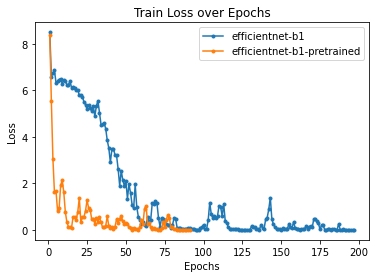

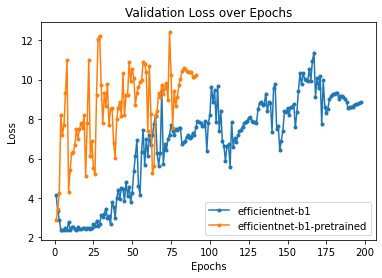

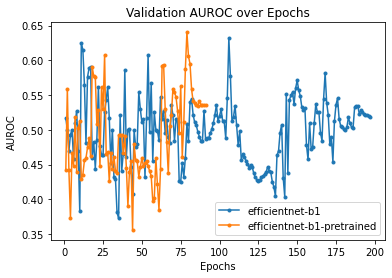

In [42]:
plt.figure()
for i in range(len(models)):
    plt.plot(range(1, epochs[i]+1), train_losses[i], label=names[i], marker=".")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Train Loss over Epochs")
plt.show()

plt.figure()
for i in range(len(models)):
    plt.plot(range(1, epochs[i]+1), valid_losses[i], label=names[i], marker=".")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Validation Loss over Epochs")
plt.show()

plt.figure()
for i in range(len(models)):
    plt.plot(range(1, epochs[i]+1), aurocs[i], label=names[i], marker=".")
plt.xlabel("Epochs")
plt.ylabel("AUROC")
plt.legend()
plt.title("Validation AUROC over Epochs")
plt.show()